#### Andrea Yoss
# ENM Project

In [1]:
#jax imports
import jax.numpy as np
from jax import random, lax, jit, grad, vmap
from jax.experimental import stax, optimizers
from jax.experimental.stax import BatchNorm, Dense, Flatten, Relu, Tanh, Sigmoid, GeneralConv, GeneralConvTranspose, Conv, ConvTranspose, serial, elementwise
from jax.nn import initializers, leaky_relu, one_hot
from jax.nn.initializers import glorot_normal, normal, ones, zeros
from jax.scipy.special import expit as sigmoid

#additional imports
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
from torchvision import datasets, transforms
import numpy as onp
from tqdm import trange
import itertools
from functools import partial
import time

In [2]:
#each layer constructor function returns an (init_fun, apply_fun) pair
###init_fun: takes rng_key and input shape, returns (output_shape, params) pair
###apply_fun: takes params, inputs and rng_key, and applies the layer

In [3]:
#Data Import

batch_size = 64

#to normalize, transform to tensor
#added resize as means to troubleshoot issues in model
transform = transforms.Compose([transforms.Resize(64), 
                                transforms.ToTensor(), 
                               transforms.Normalize(mean=(0.5), std = (0.5))])

#importing fashion mnist dataset from torchvision.datasets
#train, test data
train_dataset = datasets.FashionMNIST('traindata', train=True, download = True, transform=transform)
test_dataset = datasets.FashionMNIST('testdata', train=False, download = True, transform=transform)

#Data Loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size, 
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = 1, 
                                           shuffle = False)

In [25]:
#sampling 5000 images from dataset to address computational limitations
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

dataset_size = len(train_dataset)
dataset_indices = list(range(dataset_size))
onp.random.shuffle(dataset_indices)
train_idx = dataset_indices[:5000]
train_sampler = SubsetRandomSampler(train_idx)
mod_train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=64, sampler=train_sampler)

mod_train_loader

In [5]:
#ORIGINAL GENERATOR AND DISCRIMINATOR FUNCTIONS
#these were modified due to limitations in my computing resources 

def Generator():
    #using standard conv layer filters: 1024, 512, 256, 128
    init_fun, conv_net = stax.serial(ConvTranspose(out_chan=1024, filter_shape=(4, 4), strides=(1, 1), padding="VALID", W_init=initializers.normal(stddev=0.02)),
                                    BatchNorm(), 
                                    Relu,
                                    ConvTranspose(out_chan=512, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(),
                                    Relu,
                                    ConvTranspose(out_chan=256, filter_shape=(4, 4), strides=(2, 2)),
                                    BatchNorm(), 
                                    Relu,
                                    ConvTranspose(out_chan=128, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(),
                                    Relu,
                                    ConvTranspose(out_chan=1, filter_shape=(4, 4), strides=(2, 2), padding="SAME"), 
                                    Tanh)
                                     
    return init_fun, conv_net

def Discriminator():
    init_fun, conv_net = stax.serial(Conv(out_chan=128, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(), 
                                    Relu,
                                    Conv(out_chan=256, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(),
                                    Relu,
                                    Conv(out_chan=512, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(), 
                                    Relu,
                                    Conv(out_chan=1024, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(),
                                    Relu,
                                    Dense(out_dim=1))
    return init_fun, conv_net

In [27]:
#modified version of generator/ discriminator functions
#removed all but 2 convolutional layers

def Generator_mod():
    init_fun, conv_net = stax.serial(ConvTranspose(out_chan=512, filter_shape=(4, 4), strides=(1, 1), padding="VALID", W_init=initializers.normal(stddev=0.02)),
                                    BatchNorm(), 
                                    Relu,
                                    ConvTranspose(out_chan=256, filter_shape=(4, 4), strides=(2, 2)),padding="SAME"), 
                                    BatchNorm(), 
                                    Relu,
                                    ConvTranspose(out_chan=1, filter_shape=(4, 4), strides=(2, 2), padding="SAME"), 
                                    Tanh)
                                     
    return init_fun, conv_net

def Discriminator_mod():
    init_fun, conv_net = stax.serial(Conv(out_chan=256, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(),
                                    Relu,
                                    Conv(out_chan=512, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(), 
                                    Relu,
                                    Dense(out_dim=1))
    return init_fun, conv_net

In [36]:
class WGAN:
    # Initialize the class
    def __init__(self, init_key):

      # Set up network initialization and evaluation functions
        self.G_init, self.G_apply = Generator_mod()
        self.D_init, self.D_apply = Discriminator2_mod()
        
        #from paper
        #weight clipping
        self.c = 0.01
        #learning rate
        self.alpha = 0.00005
        #batch size
        self.batch_size = 64
        #iterations of critic before 1 generator 
        self.n_critic = 5

        # Initialize parameters, not committing to a batch shape
        k1, k2 = random.split(init_key, 2)
        _, G_params = self.G_init(k1, (-1, 1, 1, 100))
        _, D_params = self.D_init(k2, (-1, 64, 64, 1))

        # Use optimizers to set optimizer initialization and update functions
        self.G_opt_init, \
        self.G_opt_update, \
        self.G_get_params = optimizers.rmsprop(step_size = self.alpha)
        self.G_opt_state = self.G_opt_init(G_params)

        self.D_opt_init, \
        self.D_opt_update, \
        self.D_get_params = optimizers.rmsprop(step_size = self.alpha)
        self.D_opt_state = self.D_opt_init(D_params)

        # Logger
        self.G_itercount = itertools.count()
        self.D_itercount = itertools.count()
        self.batch_count = itertools.count()
        
        #removed log
        self.G_loss = []
        self.D_loss = [] 


    @partial(jit, static_argnums=(0,))
    def loss_G(self, G_params, D_params, batch):
        _, Z = batch
        # Generate fake image
        fake_image = self.G_apply(G_params, Z)
        # Evaluate discriminator output
        fake_logits = self.D_apply(D_params, fake_image)
        #loss function for generator
        # removed negative sign
        loss = onp.mean(fake_logits) 
        return loss

    @partial(jit, static_argnums=(0,))
    def loss_D(self, G_params, D_params, batch):
        X, Z = batch
        
        # Generate fake image
        fake_image = self.G_apply(G_params, Z)
        
        # Evaluate discriminator output for real and fake images
        real_logits = self.D_apply(D_params, X)
        fake_logits = self.D_apply(D_params, fake_image)
        
        # Compute Wasserstein Loss
        wasserstein_loss = onp.mean(real_logits) - onp.mean(fake_logits)
        #wasserstein_loss = real_logits - fake_logits
        return wasserstein_loss


    # Define a compiled update step for generator
    @partial(jit, static_argnums=(0,))
    def G_step(self, i, G_opt_state, D_opt_state, batch):
        G_params = self.G_get_params(G_opt_state)
        D_params = self.D_get_params(D_opt_state)
        #gradient of loss function
        g = grad(self.loss_G, 0)(G_params, D_params, batch)
        return self.G_opt_update(i, g, G_opt_state)


    # Define a compiled update step
    #clipping params at c = 0.01
    @partial(jit, static_argnums=(0,))
    def D_step(self, i, G_opt_state, D_opt_state, batch):
        G_params = self.G_get_params(G_opt_state)
        D_params = self.D_get_params(D_opt_state)
        g = grad(self.loss_D, 1)(G_params, D_params, batch)
        #clipping gradient before updating discriminator params
        g_clip = optimizers.clip_grads(g, self.c)
        return self.D_opt_update(i, g_clip, D_opt_state)



    @partial(jit, static_argnums=(0,))
    def fetch_batch(self, rng_key, inputs):
        batch_size = inputs.shape[0]
        X = inputs.reshape(batch_size, 64, 64, 1) # Inputs need to be (batch_size, width, height, channels)
        Z = random.normal(rng_key, (batch_size, 1, 1, 100))
        return X, Z

    # Optimize parameters in a loop
    def train(self, train_loader, num_epochs = 5):
       
        pbar = trange(num_epochs)
        
        for epoch in pbar:
          print("")
          #update critic params n_critic times
          for t in range(self.n_critic):
            print("Critic Update: {}".format(t))

            for batch_idx, (inputs, _) in enumerate(train_loader):

                key = random.PRNGKey(next(self.batch_count))
                
                #k1, k2 = random.split(random.PRNGKey(next(self.batch_count)), 2)
                
                # Update discriminator (critic)
                batch = self.fetch_batch(key, np.array(inputs))
                self.D_opt_state = self.D_step(next(self.D_itercount), 
                                                    self.G_opt_state, 
                                                    self.D_opt_state,
                                                    batch)
                #print("Critic Loss for update {}: {}".format(t, self.loss_D(G_params, D_params, batch)))

          # Update generator params 1x
          for batch_idx, (inputs, _) in enumerate(train_loader):

              key = random.PRNGKey(next(self.batch_count))
              
              batch = self.fetch_batch(key, np.array(inputs))
              self.G_opt_state = self.G_step(next(self.G_itercount), 
                                                    self.G_opt_state, 
                                                    self.D_opt_state,
                                                    batch)
          # Logger
          G_params = self.G_get_params(self.G_opt_state)
          D_params = self.D_get_params(self.D_opt_state)

          loss_G = self.loss_G(G_params, D_params, batch)
          loss_D = self.loss_D(G_params, D_params, batch)

          self.G_loss.append(loss_G)
          self.D_loss.append(loss_D)
          pbar.set_postfix({'Generator loss': loss_G, 'Critic loss': loss_D})

    @partial(jit, static_argnums=(0,))
    def generate(self, rng_key, G_params):
        Z = random.normal(rng_key, (1, 1, 1, 100))
        fake_image = self.G_apply(G_params, Z)
        return fake_image

In [37]:
# Initialize model
init_key = random.PRNGKey(0)
model = WGAN(init_key)

In [38]:
#using sample of 5000 for training 
model.train(mod_train_loader, num_epochs = 100)



  0%|          | 0/100 [00:00<?, ?it/s]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




  0%|          | 0/100 [00:51<?, ?it/s, Generator loss=0.12756355, Critic loss=-1.0562274]

  1%|          | 1/100 [00:51<1:25:39, 51.91s/it, Generator loss=0.12756355, Critic loss=-1.0562274]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




  1%|          | 1/100 [01:27<1:25:39, 51.91s/it, Generator loss=0.5432003, Critic loss=-1.4581733] 

  2%|▏         | 2/100 [01:27<1:17:01, 47.15s/it, Generator loss=0.5432003, Critic loss=-1.4581733]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




  2%|▏         | 2/100 [02:04<1:17:01, 47.15s/it, Generator loss=0.68774277, Critic loss=-1.4980948]

  3%|▎         | 3/100 [02:04<1:11:09, 44.01s/it, Generator loss=0.68774277, Critic loss=-1.4980948]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




  3%|▎         | 3/100 [02:41<1:11:09, 44.01s/it, Generator loss=0.43425354, Critic loss=-1.6064917]

  4%|▍         | 4/100 [02:41<1:07:10, 41.99s/it, Generator loss=0.43425354, Critic loss=-1.6064917]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




  4%|▍         | 4/100 [03:19<1:07:10, 41.99s/it, Generator loss=1.3329184, Critic loss=-2.4308832] 

  5%|▌         | 5/100 [03:19<1:04:27, 40.71s/it, Generator loss=1.3329184, Critic loss=-2.4308832]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




  5%|▌         | 5/100 [03:57<1:04:27, 40.71s/it, Generator loss=1.2208991, Critic loss=-2.1612945]

  6%|▌         | 6/100 [03:57<1:02:30, 39.90s/it, Generator loss=1.2208991, Critic loss=-2.1612945]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




  6%|▌         | 6/100 [04:35<1:02:30, 39.90s/it, Generator loss=1.9040486, Critic loss=-3.1591053]

  7%|▋         | 7/100 [04:35<1:00:58, 39.34s/it, Generator loss=1.9040486, Critic loss=-3.1591053]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




  7%|▋         | 7/100 [05:13<1:00:58, 39.34s/it, Generator loss=2.251042, Critic loss=-3.2736425] 

  8%|▊         | 8/100 [05:13<59:45, 38.98s/it, Generator loss=2.251042, Critic loss=-3.2736425]  


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




  8%|▊         | 8/100 [05:51<59:45, 38.98s/it, Generator loss=2.4556894, Critic loss=-3.975605]

  9%|▉         | 9/100 [05:51<58:43, 38.72s/it, Generator loss=2.4556894, Critic loss=-3.975605]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




  9%|▉         | 9/100 [06:30<58:43, 38.72s/it, Generator loss=2.903064, Critic loss=-4.509227] 

 10%|█         | 10/100 [06:30<57:52, 38.58s/it, Generator loss=2.903064, Critic loss=-4.509227]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 10%|█         | 10/100 [07:08<57:52, 38.58s/it, Generator loss=3.1852908, Critic loss=-4.572419]

 11%|█         | 11/100 [07:08<57:03, 38.47s/it, Generator loss=3.1852908, Critic loss=-4.572419]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 11%|█         | 11/100 [07:46<57:03, 38.47s/it, Generator loss=3.527984, Critic loss=-5.8568]   

 12%|█▏        | 12/100 [07:46<56:19, 38.40s/it, Generator loss=3.527984, Critic loss=-5.8568]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 12%|█▏        | 12/100 [08:24<56:19, 38.40s/it, Generator loss=3.946063, Critic loss=-5.991935]

 13%|█▎        | 13/100 [08:24<55:38, 38.37s/it, Generator loss=3.946063, Critic loss=-5.991935]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 13%|█▎        | 13/100 [09:03<55:38, 38.37s/it, Generator loss=4.1235704, Critic loss=-5.4544864]

 14%|█▍        | 14/100 [09:03<54:55, 38.32s/it, Generator loss=4.1235704, Critic loss=-5.4544864]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 14%|█▍        | 14/100 [09:41<54:55, 38.32s/it, Generator loss=4.0647273, Critic loss=-6.55539]  

 15%|█▌        | 15/100 [09:41<54:15, 38.30s/it, Generator loss=4.0647273, Critic loss=-6.55539]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 15%|█▌        | 15/100 [10:19<54:15, 38.30s/it, Generator loss=4.5481224, Critic loss=-6.7015266]

 16%|█▌        | 16/100 [10:19<53:39, 38.33s/it, Generator loss=4.5481224, Critic loss=-6.7015266]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 16%|█▌        | 16/100 [10:58<53:39, 38.33s/it, Generator loss=3.7332196, Critic loss=-5.0937905]

 17%|█▋        | 17/100 [10:58<53:05, 38.38s/it, Generator loss=3.7332196, Critic loss=-5.0937905]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 17%|█▋        | 17/100 [11:36<53:05, 38.38s/it, Generator loss=3.222574, Critic loss=-4.8899117] 

 18%|█▊        | 18/100 [11:36<52:23, 38.34s/it, Generator loss=3.222574, Critic loss=-4.8899117]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 18%|█▊        | 18/100 [12:14<52:23, 38.34s/it, Generator loss=3.0229187, Critic loss=-4.2084446]

 19%|█▉        | 19/100 [12:14<51:48, 38.37s/it, Generator loss=3.0229187, Critic loss=-4.2084446]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 19%|█▉        | 19/100 [12:53<51:48, 38.37s/it, Generator loss=2.2829595, Critic loss=-3.3499348]

 20%|██        | 20/100 [12:53<51:11, 38.40s/it, Generator loss=2.2829595, Critic loss=-3.3499348]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 20%|██        | 20/100 [13:31<51:11, 38.40s/it, Generator loss=3.1270604, Critic loss=-4.3108535]

 21%|██        | 21/100 [13:31<50:31, 38.37s/it, Generator loss=3.1270604, Critic loss=-4.3108535]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 21%|██        | 21/100 [14:10<50:31, 38.37s/it, Generator loss=3.0385926, Critic loss=-3.8855402]

 22%|██▏       | 22/100 [14:10<49:53, 38.38s/it, Generator loss=3.0385926, Critic loss=-3.8855402]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 22%|██▏       | 22/100 [14:48<49:53, 38.38s/it, Generator loss=3.2200212, Critic loss=-3.6647766]

 23%|██▎       | 23/100 [14:48<49:15, 38.38s/it, Generator loss=3.2200212, Critic loss=-3.6647766]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 23%|██▎       | 23/100 [15:26<49:15, 38.38s/it, Generator loss=2.8070004, Critic loss=-3.4865477]

 24%|██▍       | 24/100 [15:26<48:36, 38.37s/it, Generator loss=2.8070004, Critic loss=-3.4865477]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 24%|██▍       | 24/100 [16:05<48:36, 38.37s/it, Generator loss=3.8119845, Critic loss=-3.9666598]

 25%|██▌       | 25/100 [16:05<47:58, 38.38s/it, Generator loss=3.8119845, Critic loss=-3.9666598]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 25%|██▌       | 25/100 [16:43<47:58, 38.38s/it, Generator loss=4.1705785, Critic loss=-3.7583544]

 26%|██▌       | 26/100 [16:43<47:20, 38.39s/it, Generator loss=4.1705785, Critic loss=-3.7583544]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 26%|██▌       | 26/100 [17:22<47:20, 38.39s/it, Generator loss=3.5839837, Critic loss=-3.3415143]

 27%|██▋       | 27/100 [17:22<46:42, 38.39s/it, Generator loss=3.5839837, Critic loss=-3.3415143]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 27%|██▋       | 27/100 [18:00<46:42, 38.39s/it, Generator loss=5.0047803, Critic loss=-4.6448717]

 28%|██▊       | 28/100 [18:00<46:04, 38.39s/it, Generator loss=5.0047803, Critic loss=-4.6448717]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 28%|██▊       | 28/100 [18:38<46:04, 38.39s/it, Generator loss=4.322226, Critic loss=-4.6041036] 

 29%|██▉       | 29/100 [18:38<45:26, 38.40s/it, Generator loss=4.322226, Critic loss=-4.6041036]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 29%|██▉       | 29/100 [19:17<45:26, 38.40s/it, Generator loss=4.3674736, Critic loss=-3.7936282]

 30%|███       | 30/100 [19:17<44:47, 38.39s/it, Generator loss=4.3674736, Critic loss=-3.7936282]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 30%|███       | 30/100 [19:55<44:47, 38.39s/it, Generator loss=5.399534, Critic loss=-4.758767]  

 31%|███       | 31/100 [19:55<44:07, 38.36s/it, Generator loss=5.399534, Critic loss=-4.758767]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 31%|███       | 31/100 [20:33<44:07, 38.36s/it, Generator loss=5.585225, Critic loss=-5.4885416]

 32%|███▏      | 32/100 [20:33<43:28, 38.36s/it, Generator loss=5.585225, Critic loss=-5.4885416]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 32%|███▏      | 32/100 [21:12<43:28, 38.36s/it, Generator loss=5.2352076, Critic loss=-4.816635]

 33%|███▎      | 33/100 [21:12<42:51, 38.37s/it, Generator loss=5.2352076, Critic loss=-4.816635]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 33%|███▎      | 33/100 [21:50<42:51, 38.37s/it, Generator loss=5.173604, Critic loss=-3.834898] 

 34%|███▍      | 34/100 [21:50<42:13, 38.38s/it, Generator loss=5.173604, Critic loss=-3.834898]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 34%|███▍      | 34/100 [22:29<42:13, 38.38s/it, Generator loss=6.131518, Critic loss=-4.4472885]

 35%|███▌      | 35/100 [22:29<41:36, 38.40s/it, Generator loss=6.131518, Critic loss=-4.4472885]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 35%|███▌      | 35/100 [23:07<41:36, 38.40s/it, Generator loss=5.9257956, Critic loss=-5.5224895]

 36%|███▌      | 36/100 [23:07<40:57, 38.40s/it, Generator loss=5.9257956, Critic loss=-5.5224895]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 36%|███▌      | 36/100 [23:45<40:57, 38.40s/it, Generator loss=6.1361938, Critic loss=-5.488612] 

 37%|███▋      | 37/100 [23:45<40:19, 38.41s/it, Generator loss=6.1361938, Critic loss=-5.488612]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 37%|███▋      | 37/100 [24:24<40:19, 38.41s/it, Generator loss=6.8321347, Critic loss=-5.562185]

 38%|███▊      | 38/100 [24:24<39:41, 38.41s/it, Generator loss=6.8321347, Critic loss=-5.562185]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 38%|███▊      | 38/100 [25:02<39:41, 38.41s/it, Generator loss=6.7689013, Critic loss=-6.6550756]

 39%|███▉      | 39/100 [25:02<39:03, 38.42s/it, Generator loss=6.7689013, Critic loss=-6.6550756]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 39%|███▉      | 39/100 [25:41<39:03, 38.42s/it, Generator loss=6.9334216, Critic loss=-5.4471006]

 40%|████      | 40/100 [25:41<38:24, 38.41s/it, Generator loss=6.9334216, Critic loss=-5.4471006]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 40%|████      | 40/100 [26:19<38:24, 38.41s/it, Generator loss=7.271151, Critic loss=-5.562448]  

 41%|████      | 41/100 [26:19<37:45, 38.41s/it, Generator loss=7.271151, Critic loss=-5.562448]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 41%|████      | 41/100 [26:58<37:45, 38.41s/it, Generator loss=7.193925, Critic loss=-6.4363375]

 42%|████▏     | 42/100 [26:58<37:07, 38.40s/it, Generator loss=7.193925, Critic loss=-6.4363375]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 42%|████▏     | 42/100 [27:36<37:07, 38.40s/it, Generator loss=7.2064567, Critic loss=-6.816325]

 43%|████▎     | 43/100 [27:36<36:29, 38.42s/it, Generator loss=7.2064567, Critic loss=-6.816325]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 43%|████▎     | 43/100 [28:14<36:29, 38.42s/it, Generator loss=7.3017907, Critic loss=-5.97371] 

 44%|████▍     | 44/100 [28:14<35:51, 38.42s/it, Generator loss=7.3017907, Critic loss=-5.97371]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 44%|████▍     | 44/100 [28:53<35:51, 38.42s/it, Generator loss=7.0993476, Critic loss=-6.352971]

 45%|████▌     | 45/100 [28:53<35:12, 38.41s/it, Generator loss=7.0993476, Critic loss=-6.352971]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 45%|████▌     | 45/100 [29:31<35:12, 38.41s/it, Generator loss=7.3146305, Critic loss=-7.2273655]

 46%|████▌     | 46/100 [29:31<34:33, 38.40s/it, Generator loss=7.3146305, Critic loss=-7.2273655]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 46%|████▌     | 46/100 [30:10<34:33, 38.40s/it, Generator loss=7.0677967, Critic loss=-5.77074]  

 47%|████▋     | 47/100 [30:10<33:54, 38.39s/it, Generator loss=7.0677967, Critic loss=-5.77074]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 47%|████▋     | 47/100 [30:48<33:54, 38.39s/it, Generator loss=7.2373905, Critic loss=-5.9176226]

 48%|████▊     | 48/100 [30:48<33:18, 38.43s/it, Generator loss=7.2373905, Critic loss=-5.9176226]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 48%|████▊     | 48/100 [31:26<33:18, 38.43s/it, Generator loss=6.4702616, Critic loss=-5.728662] 

 49%|████▉     | 49/100 [31:26<32:39, 38.43s/it, Generator loss=6.4702616, Critic loss=-5.728662]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 49%|████▉     | 49/100 [32:05<32:39, 38.43s/it, Generator loss=8.435768, Critic loss=-6.850086] 

 50%|█████     | 50/100 [32:05<32:01, 38.42s/it, Generator loss=8.435768, Critic loss=-6.850086]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 50%|█████     | 50/100 [32:43<32:01, 38.42s/it, Generator loss=7.6130786, Critic loss=-6.6643586]

 51%|█████     | 51/100 [32:43<31:22, 38.41s/it, Generator loss=7.6130786, Critic loss=-6.6643586]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 51%|█████     | 51/100 [33:22<31:22, 38.41s/it, Generator loss=8.562039, Critic loss=-8.053613]  

 52%|█████▏    | 52/100 [33:22<30:43, 38.40s/it, Generator loss=8.562039, Critic loss=-8.053613]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 52%|█████▏    | 52/100 [34:00<30:43, 38.40s/it, Generator loss=8.46223, Critic loss=-7.5391393]

 53%|█████▎    | 53/100 [34:00<30:04, 38.39s/it, Generator loss=8.46223, Critic loss=-7.5391393]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 53%|█████▎    | 53/100 [34:38<30:04, 38.39s/it, Generator loss=8.47723, Critic loss=-6.1141977]

 54%|█████▍    | 54/100 [34:38<29:26, 38.40s/it, Generator loss=8.47723, Critic loss=-6.1141977]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 54%|█████▍    | 54/100 [35:17<29:26, 38.40s/it, Generator loss=8.228845, Critic loss=-7.625575]

 55%|█████▌    | 55/100 [35:17<28:47, 38.40s/it, Generator loss=8.228845, Critic loss=-7.625575]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 55%|█████▌    | 55/100 [35:55<28:47, 38.40s/it, Generator loss=8.693587, Critic loss=-7.2349033]

 56%|█████▌    | 56/100 [35:55<28:09, 38.40s/it, Generator loss=8.693587, Critic loss=-7.2349033]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 56%|█████▌    | 56/100 [36:34<28:09, 38.40s/it, Generator loss=8.022005, Critic loss=-6.8546104]

 57%|█████▋    | 57/100 [36:34<27:31, 38.41s/it, Generator loss=8.022005, Critic loss=-6.8546104]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 57%|█████▋    | 57/100 [37:12<27:31, 38.41s/it, Generator loss=8.42562, Critic loss=-6.5501184] 

 58%|█████▊    | 58/100 [37:12<26:53, 38.42s/it, Generator loss=8.42562, Critic loss=-6.5501184]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 58%|█████▊    | 58/100 [37:50<26:53, 38.42s/it, Generator loss=8.29914, Critic loss=-7.8634186]

 59%|█████▉    | 59/100 [37:51<26:14, 38.41s/it, Generator loss=8.29914, Critic loss=-7.8634186]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 59%|█████▉    | 59/100 [38:29<26:14, 38.41s/it, Generator loss=8.704604, Critic loss=-7.539794]

 60%|██████    | 60/100 [38:29<25:36, 38.41s/it, Generator loss=8.704604, Critic loss=-7.539794]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 60%|██████    | 60/100 [39:07<25:36, 38.41s/it, Generator loss=8.810963, Critic loss=-7.2421045]

 61%|██████    | 61/100 [39:07<24:58, 38.41s/it, Generator loss=8.810963, Critic loss=-7.2421045]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 61%|██████    | 61/100 [39:46<24:58, 38.41s/it, Generator loss=8.856113, Critic loss=-7.138708] 

 62%|██████▏   | 62/100 [39:46<24:18, 38.38s/it, Generator loss=8.856113, Critic loss=-7.138708]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 62%|██████▏   | 62/100 [40:24<24:18, 38.38s/it, Generator loss=8.410376, Critic loss=-8.144546]

 63%|██████▎   | 63/100 [40:24<23:40, 38.38s/it, Generator loss=8.410376, Critic loss=-8.144546]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 63%|██████▎   | 63/100 [41:02<23:40, 38.38s/it, Generator loss=8.624375, Critic loss=-6.3126187]

 64%|██████▍   | 64/100 [41:02<23:02, 38.40s/it, Generator loss=8.624375, Critic loss=-6.3126187]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 64%|██████▍   | 64/100 [41:41<23:02, 38.40s/it, Generator loss=9.072191, Critic loss=-8.642912] 

 65%|██████▌   | 65/100 [41:41<22:23, 38.39s/it, Generator loss=9.072191, Critic loss=-8.642912]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 65%|██████▌   | 65/100 [42:19<22:23, 38.39s/it, Generator loss=9.448444, Critic loss=-8.085612]

 66%|██████▌   | 66/100 [42:19<21:45, 38.39s/it, Generator loss=9.448444, Critic loss=-8.085612]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 66%|██████▌   | 66/100 [42:58<21:45, 38.39s/it, Generator loss=9.509122, Critic loss=-8.715666]

 67%|██████▋   | 67/100 [42:58<21:06, 38.38s/it, Generator loss=9.509122, Critic loss=-8.715666]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 67%|██████▋   | 67/100 [43:36<21:06, 38.38s/it, Generator loss=9.697119, Critic loss=-8.33097] 

 68%|██████▊   | 68/100 [43:36<20:28, 38.39s/it, Generator loss=9.697119, Critic loss=-8.33097]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 68%|██████▊   | 68/100 [44:14<20:28, 38.39s/it, Generator loss=9.336669, Critic loss=-8.063779]

 69%|██████▉   | 69/100 [44:14<19:49, 38.37s/it, Generator loss=9.336669, Critic loss=-8.063779]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 69%|██████▉   | 69/100 [44:53<19:49, 38.37s/it, Generator loss=9.4848585, Critic loss=-8.048752]

 70%|███████   | 70/100 [44:53<19:10, 38.36s/it, Generator loss=9.4848585, Critic loss=-8.048752]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 70%|███████   | 70/100 [45:31<19:10, 38.36s/it, Generator loss=9.122376, Critic loss=-8.086806] 

 71%|███████   | 71/100 [45:31<18:32, 38.36s/it, Generator loss=9.122376, Critic loss=-8.086806]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 71%|███████   | 71/100 [46:09<18:32, 38.36s/it, Generator loss=9.595405, Critic loss=-9.139708]

 72%|███████▏  | 72/100 [46:09<17:54, 38.37s/it, Generator loss=9.595405, Critic loss=-9.139708]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 72%|███████▏  | 72/100 [46:48<17:54, 38.37s/it, Generator loss=9.641403, Critic loss=-8.342438]

 73%|███████▎  | 73/100 [46:48<17:16, 38.37s/it, Generator loss=9.641403, Critic loss=-8.342438]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 73%|███████▎  | 73/100 [47:26<17:16, 38.37s/it, Generator loss=9.87974, Critic loss=-8.711982] 

 74%|███████▍  | 74/100 [47:26<16:37, 38.38s/it, Generator loss=9.87974, Critic loss=-8.711982]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 74%|███████▍  | 74/100 [48:05<16:37, 38.38s/it, Generator loss=8.712689, Critic loss=-5.6381226]

 75%|███████▌  | 75/100 [48:05<15:59, 38.39s/it, Generator loss=8.712689, Critic loss=-5.6381226]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 75%|███████▌  | 75/100 [48:43<15:59, 38.39s/it, Generator loss=9.961345, Critic loss=-7.830121] 

 76%|███████▌  | 76/100 [48:43<15:21, 38.41s/it, Generator loss=9.961345, Critic loss=-7.830121]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 76%|███████▌  | 76/100 [49:21<15:21, 38.41s/it, Generator loss=9.830784, Critic loss=-8.3936205]

 77%|███████▋  | 77/100 [49:21<14:43, 38.41s/it, Generator loss=9.830784, Critic loss=-8.3936205]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 77%|███████▋  | 77/100 [50:00<14:43, 38.41s/it, Generator loss=9.925522, Critic loss=-8.087137] 

 78%|███████▊  | 78/100 [50:00<14:04, 38.40s/it, Generator loss=9.925522, Critic loss=-8.087137]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 78%|███████▊  | 78/100 [50:38<14:04, 38.40s/it, Generator loss=10.40831, Critic loss=-6.4717703]

 79%|███████▉  | 79/100 [50:38<13:26, 38.40s/it, Generator loss=10.40831, Critic loss=-6.4717703]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 79%|███████▉  | 79/100 [51:17<13:26, 38.40s/it, Generator loss=10.403054, Critic loss=-9.573022]

 80%|████████  | 80/100 [51:17<12:47, 38.40s/it, Generator loss=10.403054, Critic loss=-9.573022]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 80%|████████  | 80/100 [51:55<12:47, 38.40s/it, Generator loss=10.0994625, Critic loss=-9.135037]

 81%|████████  | 81/100 [51:55<12:09, 38.39s/it, Generator loss=10.0994625, Critic loss=-9.135037]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 81%|████████  | 81/100 [52:33<12:09, 38.39s/it, Generator loss=9.152684, Critic loss=-6.4687853] 

 82%|████████▏ | 82/100 [52:33<11:30, 38.38s/it, Generator loss=9.152684, Critic loss=-6.4687853]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 82%|████████▏ | 82/100 [53:12<11:30, 38.38s/it, Generator loss=10.483569, Critic loss=-9.5905285]

 83%|████████▎ | 83/100 [53:12<10:52, 38.39s/it, Generator loss=10.483569, Critic loss=-9.5905285]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 83%|████████▎ | 83/100 [53:50<10:52, 38.39s/it, Generator loss=11.115496, Critic loss=-9.079031] 

 84%|████████▍ | 84/100 [53:50<10:15, 38.45s/it, Generator loss=11.115496, Critic loss=-9.079031]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 84%|████████▍ | 84/100 [54:29<10:15, 38.45s/it, Generator loss=11.074356, Critic loss=-8.271011]

 85%|████████▌ | 85/100 [54:29<09:37, 38.52s/it, Generator loss=11.074356, Critic loss=-8.271011]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 85%|████████▌ | 85/100 [55:08<09:37, 38.52s/it, Generator loss=10.76071, Critic loss=-9.725506] 

 86%|████████▌ | 86/100 [55:08<08:59, 38.52s/it, Generator loss=10.76071, Critic loss=-9.725506]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 86%|████████▌ | 86/100 [55:46<08:59, 38.52s/it, Generator loss=10.969426, Critic loss=-9.468643]

 87%|████████▋ | 87/100 [55:46<08:21, 38.54s/it, Generator loss=10.969426, Critic loss=-9.468643]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 87%|████████▋ | 87/100 [56:25<08:21, 38.54s/it, Generator loss=10.409682, Critic loss=-8.503168]

 88%|████████▊ | 88/100 [56:25<07:43, 38.59s/it, Generator loss=10.409682, Critic loss=-8.503168]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 88%|████████▊ | 88/100 [57:04<07:43, 38.59s/it, Generator loss=10.183174, Critic loss=-8.206638]

 89%|████████▉ | 89/100 [57:04<07:04, 38.61s/it, Generator loss=10.183174, Critic loss=-8.206638]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 89%|████████▉ | 89/100 [57:42<07:04, 38.61s/it, Generator loss=10.895754, Critic loss=-10.072339]

 90%|█████████ | 90/100 [57:42<06:26, 38.63s/it, Generator loss=10.895754, Critic loss=-10.072339]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 90%|█████████ | 90/100 [58:21<06:26, 38.63s/it, Generator loss=10.804759, Critic loss=-9.268982] 

 91%|█████████ | 91/100 [58:21<05:47, 38.62s/it, Generator loss=10.804759, Critic loss=-9.268982]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 91%|█████████ | 91/100 [58:59<05:47, 38.62s/it, Generator loss=10.975451, Critic loss=-10.463956]

 92%|█████████▏| 92/100 [58:59<05:09, 38.63s/it, Generator loss=10.975451, Critic loss=-10.463956]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 92%|█████████▏| 92/100 [59:38<05:09, 38.63s/it, Generator loss=11.521616, Critic loss=-7.2882094]

 93%|█████████▎| 93/100 [59:38<04:30, 38.61s/it, Generator loss=11.521616, Critic loss=-7.2882094]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 93%|█████████▎| 93/100 [1:00:16<04:30, 38.61s/it, Generator loss=11.117159, Critic loss=-9.762524]

 94%|█████████▍| 94/100 [1:00:16<03:51, 38.58s/it, Generator loss=11.117159, Critic loss=-9.762524]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 94%|█████████▍| 94/100 [1:00:55<03:51, 38.58s/it, Generator loss=11.763882, Critic loss=-9.116914]

 95%|█████████▌| 95/100 [1:00:55<03:13, 38.60s/it, Generator loss=11.763882, Critic loss=-9.116914]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 95%|█████████▌| 95/100 [1:01:34<03:13, 38.60s/it, Generator loss=11.217552, Critic loss=-9.518917]

 96%|█████████▌| 96/100 [1:01:34<02:34, 38.61s/it, Generator loss=11.217552, Critic loss=-9.518917]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 96%|█████████▌| 96/100 [1:02:12<02:34, 38.61s/it, Generator loss=11.597999, Critic loss=-10.352422]

 97%|█████████▋| 97/100 [1:02:12<01:55, 38.62s/it, Generator loss=11.597999, Critic loss=-10.352422]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 97%|█████████▋| 97/100 [1:02:51<01:55, 38.62s/it, Generator loss=11.290693, Critic loss=-9.306901] 

 98%|█████████▊| 98/100 [1:02:51<01:17, 38.61s/it, Generator loss=11.290693, Critic loss=-9.306901]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 98%|█████████▊| 98/100 [1:03:30<01:17, 38.61s/it, Generator loss=11.3024025, Critic loss=-9.91312]

 99%|█████████▉| 99/100 [1:03:30<00:38, 38.60s/it, Generator loss=11.3024025, Critic loss=-9.91312]


Critic Update: 0
Critic Update: 1
Critic Update: 2
Critic Update: 3
Critic Update: 4




 99%|█████████▉| 99/100 [1:04:08<00:38, 38.60s/it, Generator loss=11.975176, Critic loss=-10.920971]

100%|██████████| 100/100 [1:04:08<00:00, 38.49s/it, Generator loss=11.975176, Critic loss=-10.920971]


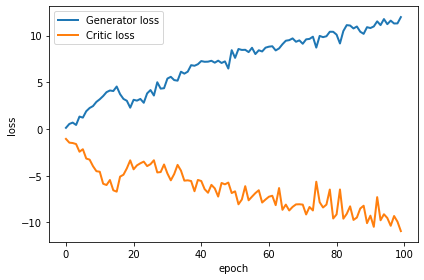

In [43]:
plt.figure()
plt.plot(model.G_loss, lw = 2, label = 'Generator loss')
plt.plot(model.D_loss, lw = 2, label = 'Critic loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.tight_layout()

In [75]:
# Generate some samples
num_samples = 64
Z = random.normal(random.PRNGKey(0), (num_samples, 1, 1, 100))
G_params = model.G_get_params(model.G_opt_state)
images = model.G_apply(G_params, Z)

(64, 20, 20, 1)


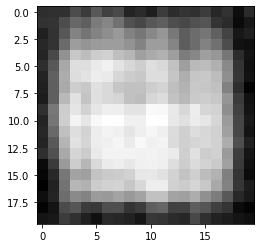

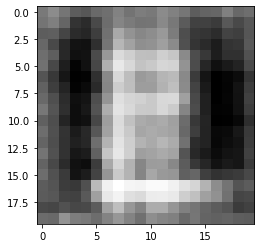

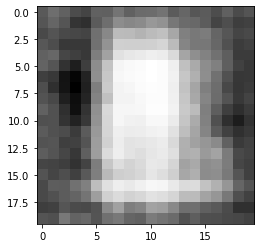

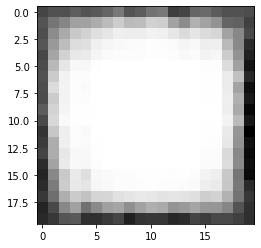

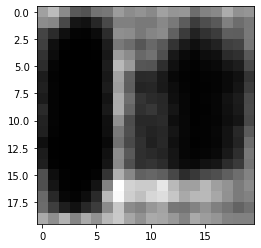

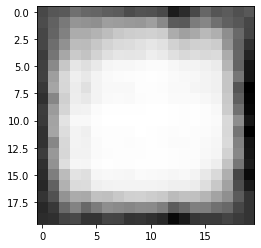

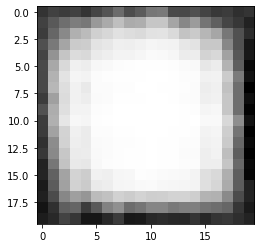

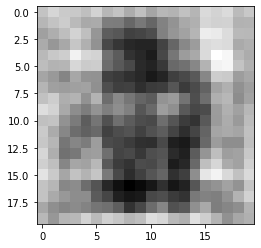

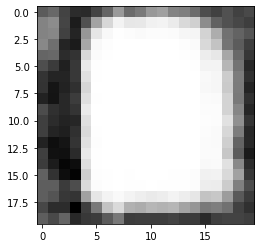

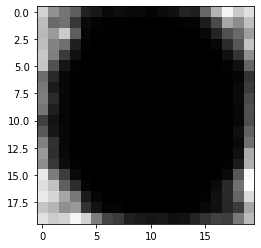

In [77]:
# plot some samples
print(images.shape)
for k in range(10):
  fig = plt.figure(k)
  plt.imshow(images[k,:,:,0], cmap='gray')
  plt.show();

In [ ]:
#to use instead of relu in discriminator/ critic nn
#used in paper 
Leaky_Relu = elementwise(leaky_relu, negative_slope=0.2)

def Discriminator2():
    init_fun, conv_net = stax.serial(Conv(out_chan=128, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(), 
                                    Leaky_Relu,
                                    Conv(out_chan=256, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(),
                                    Leaky_Relu,
                                    Conv(out_chan=512, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(), 
                                    Leaky_Relu,
                                    Conv(out_chan=1024, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(),
                                    Leaky_Relu,
                                    Dense(out_dim=1))
    return init_fun, conv_net

In [35]:
#to use instead of relu in discriminator/ critic nn
#used in paper 
Leaky_Relu = elementwise(leaky_relu, negative_slope=0.2)

def Discriminator2_mod():
    init_fun, conv_net = stax.serial(Conv(out_chan=256, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(),
                                    Leaky_Relu,
                                    Conv(out_chan=512, filter_shape=(4, 4), strides=(2, 2), padding="SAME"),
                                    BatchNorm(), 
                                    Leaky_Relu,
                                    Dense(out_dim=1))
    return init_fun, conv_net

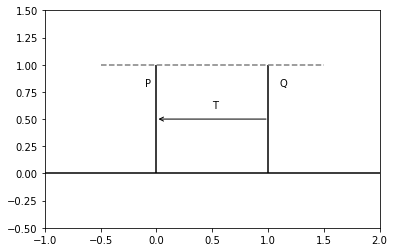

In [72]:
#visual for parallel lines example
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.axis([-1,2, -.5, 1.5])
plt.hlines(0,-1,2)
plt.vlines(0, 0, 1)
ax.text(0-.1,.8, 'P')
plt.vlines(1, 0, 1)
ax.text(1.1,.8, 'Q')
ax.annotate("", xy=(1, 0.5), xytext=(0, 0.5),arrowprops=dict(arrowstyle="<-"))
plt.hlines(1,-.5,1.5, linestyles='dashed', colors='grey')
ax.text(.5,.6, 'T');
plt.savefig('parallel_example.png')
